In [1]:
# Necessary imports
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt 
import umap.plot as uplot
import umap.umap_ as umap
import hdbscan
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

2024-02-27 21:42:59.556865: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 21:43:00.060136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 21:43:00.060237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 21:43:00.168605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 21:43:00.385842: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 21:43:00.388269: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Clustering
By utilizing clustering on our data we minimize the search space making recommendations more computationally efficient and deepend the quality of recommendations for users within clusters. Clustering was accomplished with UMAP and scikit-learn.

### Handling slight preprocessing
Before exploring clustering results we load in our data with BERT embeddings and apply scikit-learn vectorization methods.

In [2]:
# Loading in the data for tf-idf and bag of words vectorization methods.
news_text = pd.read_csv('../MIND_large/csv/news.csv', index_col=0).set_index('news_id').drop(columns=['url','title_entities','abstract_entities'])
news_text = news_text[news_text['abstract'].isna() == False]
news_text.head()

,category,sub_category,title,abstract
news_id,,,,
N88753,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
N23144,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
N93187,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
N75236,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
N99744,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


In [3]:
# Initialize vectorizers from scikit-learn
bow_vectorizer = CountVectorizer(stop_words='english')
tf_vectorizer = TfidfVectorizer(stop_words='english')

# Create bag of words and tf-idf matrices of the corpus
bow_matrix = bow_vectorizer.fit_transform(news_text['abstract'] + news_text['title'])
tf_matrix = tf_vectorizer.fit_transform(news_text['abstract'] + news_text['title'])

In [4]:
def create_UMAP_embeddings(dimension, data, metric='hellinger'):
    """
    Performes umap dimension reduction on the data up to the dimension specified by the associated parameter
    """
    embeddings = umap.UMAP(
        n_neighbors=30,
        min_dist=0.0,
        n_components=dimension,
        metric = metric,
        n_jobs = 4,
    ).fit_transform(data)
    return embeddings
    

In [10]:
hellinger_bow_embeddings = create_UMAP_embeddings(2, bow_matrix)
hellinger_tf_embeddings = create_UMAP_embeddings(2, tf_matrix)

/opt/conda/lib/python3.11/site-packages/pynndescent/pynndescent_.py:1626: RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger
  self._distance_correction(self._neighbor_graph[1]),


In [12]:
euclidian_bow_embeddings = create_UMAP_embeddings(2, bow_matrix, 'euclidean')
euclidian_tf_embeddings = create_UMAP_embeddings(2, tf_matrix, 'euclidean')

In [13]:
import sklearn.cluster as cluster

In [6]:
def create_hdbscan_labels(embeddings, min_samples=10, min_cluster_size=100):
    """ 
    Creates labels from the dbscan clustering algorithm
    """
    return hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size).fit_predict(embeddings)

def create_kmeans_labels(embeddings, n_clusters=10):
    """
    Creates labels from the kmeans clustering algorithm
    """   
    return cluster.KMeans(n_clusters = n_clusters).fit_predict(embeddings)
    

In [48]:
bow_hellinger_hdbscan_labels = create_hdbscan_labels(hellinger_bow_embeddings)
tf_hellinger_hdbscan_labels = create_hdbscan_labels(hellinger_tf_embeddings)
bow_hellinger_kmeans_labels = create_kmeans_labels(hellinger_bow_embeddings)
tf_hellinger_kmeans_labels = create_kmeans_labels(hellinger_tf_embeddings)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [49]:
bow_euclidean_hdbscan_labels = create_hdbscan_labels(euclidian_bow_embeddings)
tf_euclidean_hdbscan_labels = create_hdbscan_labels(euclidian_tf_embeddings)
bow_euclidean_kmeans_labels = create_kmeans_labels(euclidian_bow_embeddings)
tf_euclidean_kmeans_labels = create_kmeans_labels(euclidian_tf_embeddings)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import numpy as np

In [45]:
cmap = matplotlib.colormaps['plasma']

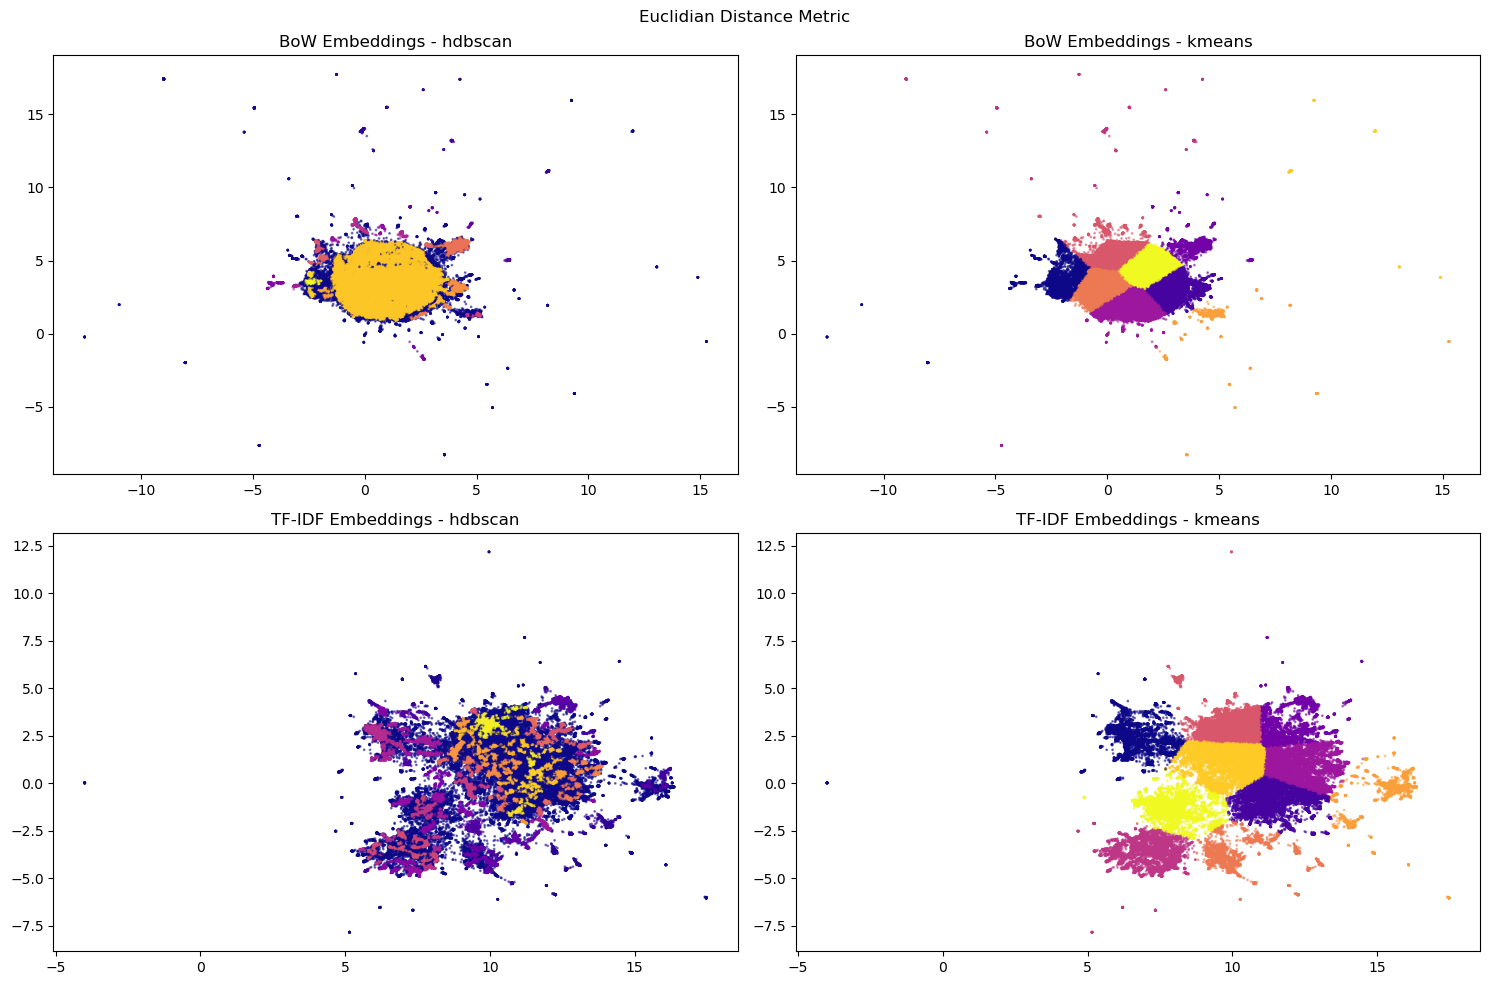

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
# labels = [bow_hellinger_hdbscan_labels, bow_hellinger_kmeans_labels, tf_hellinger_hdbscan_labels, tf_hellinger_kmeans_labels]
axs = axs.flatten()
axs[0].scatter(euclidian_bow_embeddings[:, 0],euclidian_bow_embeddings[:, 1], alpha = 0.5, s=1, c=bow_euclidean_hdbscan_labels, cmap=cmap)
axs[1].scatter(euclidian_bow_embeddings[:, 0],euclidian_bow_embeddings[:, 1], alpha = 0.5, s=1, c=bow_euclidean_kmeans_labels, cmap=cmap)
axs[2].scatter(euclidian_tf_embeddings[:, 0], euclidian_tf_embeddings[:, 1], alpha = 0.5, s=1, c=tf_euclidean_hdbscan_labels, cmap=cmap)
axs[3].scatter(euclidian_tf_embeddings[:, 0], euclidian_tf_embeddings[:, 1], alpha = 0.5, s=1, c=tf_euclidean_kmeans_labels, cmap=cmap)
fig.suptitle("Euclidian Distance Metric")
axs[0].set_title('BoW Embeddings - hdbscan')
axs[1].set_title('BoW Embeddings - kmeans')
axs[2].set_title('TF-IDF Embeddings - hdbscan')
axs[3].set_title('TF-IDF Embeddings - kmeans')
plt.tight_layout()
plt.show();

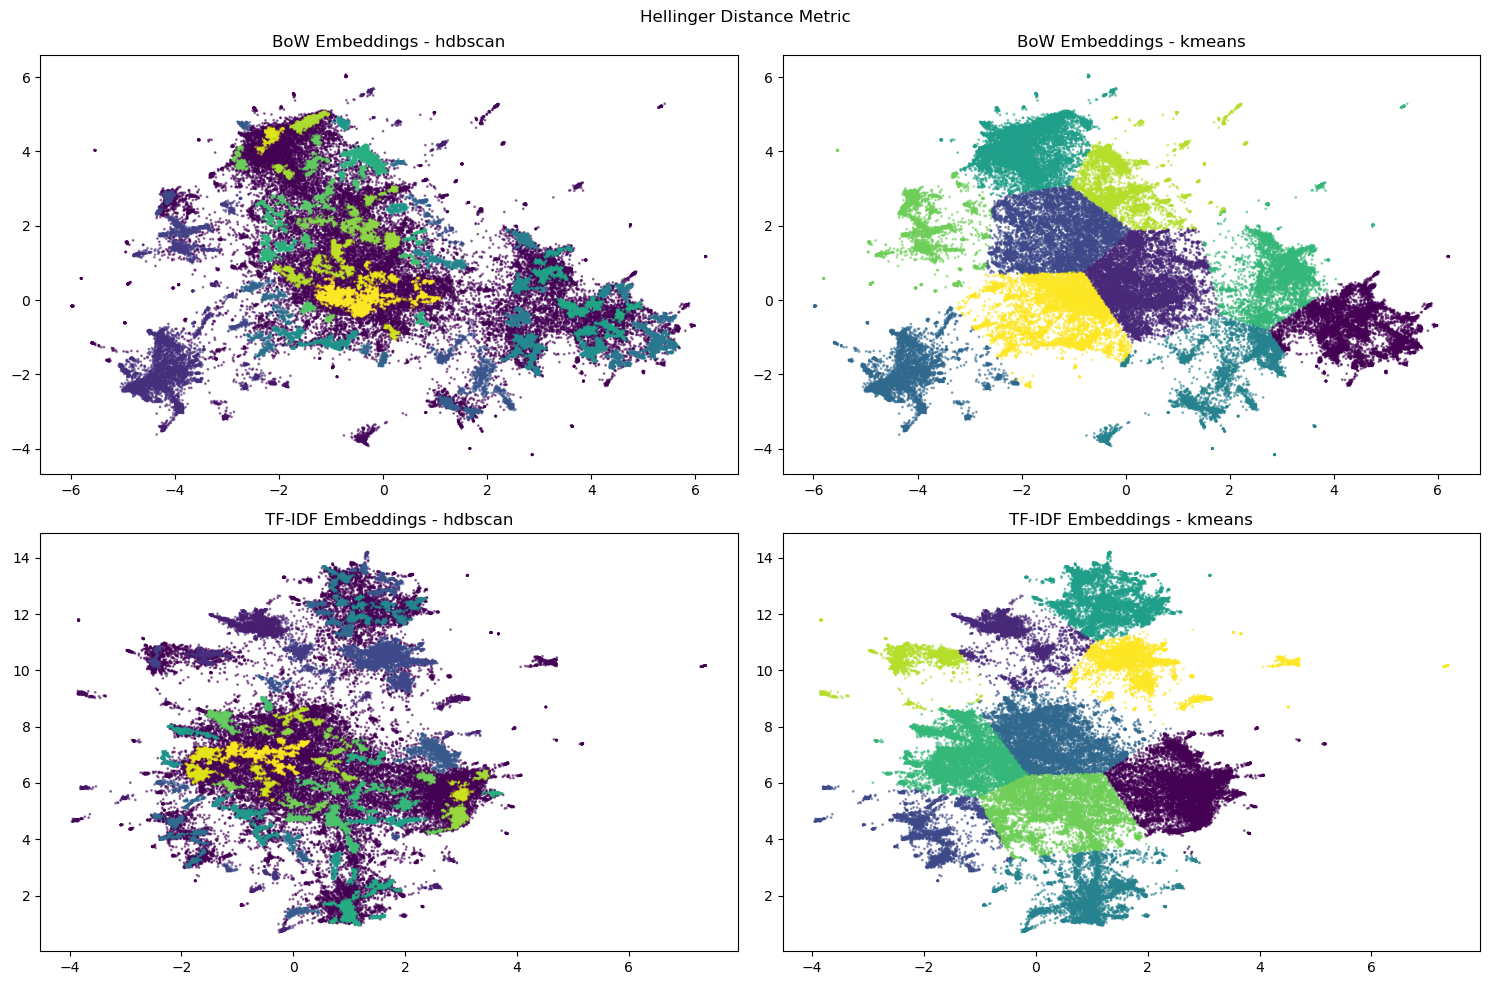

In [52]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
# labels = [bow_hellinger_hdbscan_labels, bow_hellinger_kmeans_labels, tf_hellinger_hdbscan_labels, tf_hellinger_kmeans_labels]
axs = axs.flatten()
axs[0].scatter(hellinger_bow_embeddings[:, 0],hellinger_bow_embeddings[:, 1], alpha = 0.5, s=1, c=bow_hellinger_hdbscan_labels)
axs[1].scatter(hellinger_bow_embeddings[:, 0],hellinger_bow_embeddings[:, 1], alpha = 0.5, s=1, c=bow_hellinger_kmeans_labels)
axs[2].scatter(hellinger_tf_embeddings[:, 0], hellinger_tf_embeddings[:, 1], alpha = 0.5, s=1, c=tf_hellinger_hdbscan_labels)
axs[3].scatter(hellinger_tf_embeddings[:, 0], hellinger_tf_embeddings[:, 1], alpha = 0.5, s=1, c=tf_hellinger_kmeans_labels)
fig.suptitle('Hellinger Distance Metric')
axs[0].set_title('BoW Embeddings - hdbscan')
axs[1].set_title('BoW Embeddings - kmeans')
axs[2].set_title('TF-IDF Embeddings - hdbscan')
axs[3].set_title('TF-IDF Embeddings - kmeans')
plt.tight_layout()
plt.show();

By clustering we can see that text vectorized by tf-idf has a much wider spread and more clearly defined clusters after being pushed into two dimensions. Due to this structure we utilize tf-idf embeddings for clustering.

### Creating a user-item matrix
With reduced dimension embeddings created we can then move on to creating the user item matrix

In [5]:
higher_dim_bow = create_UMAP_embeddings(50, bow_matrix)
higher_dim_tf = create_UMAP_embeddings(50, tf_matrix)



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/conda/lib/python3.11/site-packages/pynndescent/pynndescent_.py:1626: RuntimeWarning: invalid value encountered in sparse_correct_alternative_hellinger
  self._distance_correction(self._neighbor_graph[1]),


NameError: name 'create_hdbscan_labels' is not defined

In [7]:
bow_hdbscan_labels = create_hdbscan_labels(higher_dim_bow)
tf_hdbscan_labels = create_hdbscan_labels(higher_dim_tf)

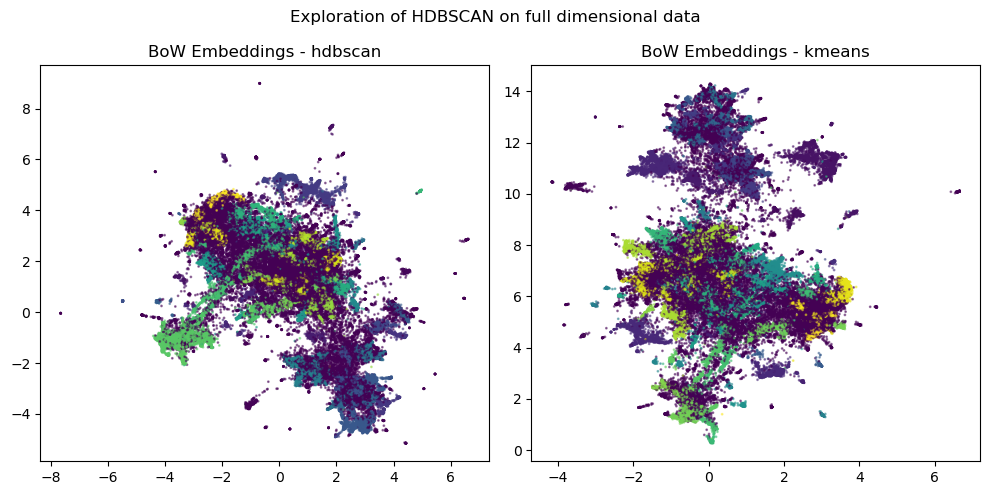

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
# labels = [bow_hellinger_hdbscan_labels, bow_hellinger_kmeans_labels, tf_hellinger_hdbscan_labels, tf_hellinger_kmeans_labels]
axs = axs.flatten()
axs[0].scatter(hellinger_bow_embeddings[:, 0],hellinger_bow_embeddings[:, 1], alpha = 0.5, s=1, c=bow_hdbscan_labels)
axs[1].scatter(hellinger_tf_embeddings[:, 0], hellinger_tf_embeddings[:, 1], alpha = 0.5, s=1, c=tf_hdbscan_labels)

fig.suptitle("Exploration of HDBSCAN on higher dimensional data")
axs[0].set_title('BoW Embeddings - hdbscan')
axs[1].set_title('BoW Embeddings - kmeans')

plt.tight_layout()
plt.show();

In [ ]:
def tune_clustering(matrix, n_components=50, metric='euclidean', min_cluster_size=500, n_neighbors=30):
    umap_embeddings = umap.UMAP(
        n_neighbors=30,
        min_dist=0.0,
        n_components=n_components,
        random_state=42,
        metric=metric
    ).fit_transform(matrix)
    hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings)
    clustered = (hdbscan_labels >= 0)
    print(f"CLUSTERED: Adjusted random score is: {adjusted_rand_score(news_text['category'][clustered], hdbscan_labels[clustered])},\n Adjusted mutual info is: {adjusted_mutual_info_score(news_text['category'][clustered], hdbscan_labels[clustered])}")
    print(f"Adjusted random score is: {adjusted_rand_score(news_text['category'], hdbscan_labels)},\n Adjusted mutual info is: {adjusted_mutual_info_score(news_text['category'], hdbscan_labels)}")    

In [ ]:
def tune_clustering(matrix, labels, mat_name, n_components=50, metric='euclidean', min_cluster_size=500, n_neighbors=30, min_dist=0.0, min_samples=5, random_state=42, counter=0):
    """
    Tune clustering parameters and evaluate clustering performance.

    Parameters:
    - matrix: Data matrix to cluster.
    - labels: True labels for evaluation.
    - n_components: Number of dimensions for UMAP.
    - metric: Distance metric for UMAP.
    - min_cluster_size: Minimum cluster size for HDBSCAN.
    - n_neighbors: Number of neighbors for UMAP.
    - min_dist: Minimum distance between points in UMAP space.
    - min_samples: Minimum samples for HDBSCAN.
    - random_state: Random state for reproducibility.

    Returns:
    - Prints evaluation scores.
    """
    try:
        umap_embeddings = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            random_state=random_state,
            metric=metric,
        ).fit_transform(matrix)
        
        hdbscan_labels = hdbscan.HDBSCAN(
            min_samples=min_samples,
            min_cluster_size=min_cluster_size
        ).fit_predict(umap_embeddings)
        
        clustered = (hdbscan_labels >= 0)
        if clustered.any():
            data = pd.DataFrame(data = {'mat' : mat_name, 'n_neighbors' : n_neighbors, 'min_dist' : min_dist, 'n_components' : n_components, 'metric' : metric, 'min_samples' : min_samples, 'min_dist' : min_dist,
                                    'clustered_rand' : adjusted_rand_score(labels[clustered], hdbscan_labels[clustered]),
                                    'clustered_info' : adjusted_mutual_info_score(labels[clustered], hdbscan_labels[clustered]),
                                    'overall_rand' : adjusted_rand_score(labels, hdbscan_labels),
                                    'overall_info' : adjusted_mutual_info_score(labels, hdbscan_labels)})

            data.to_csv('cluster_tuning.csv', mode='a', index = [counter])

        else:
            print("No clusters formed with the given parameters.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
n_components_range = [10, 50, 100]
min_cluster_size_range = [100, 500, 1000]
n_neighbors_range = [10, 30, 50]
min_dist_range = [0.0, 0.1, 0.5]
min_samples_range = [5, 10, 20]

# Iterate over each parameter range
counter = 0
for n_components in n_components_range:
    for min_cluster_size in min_cluster_size_range:
        for n_neighbors in n_neighbors_range:
            for min_dist in min_dist_range:
                for min_samples in min_samples_range:
                    print(f"Testing parameters: n_components={n_components}, min_cluster_size={min_cluster_size}, "
                          f"n_neighbors={n_neighbors}, min_dist={min_dist}, min_samples={min_samples}")
                    
                    tune_clustering(tf_matrix, news_text['category'],
                                    'tfidf',
                                    n_components=n_components, 
                                    metric='euclidean', 
                                    min_cluster_size=min_cluster_size, 
                                    n_neighbors=n_neighbors, 
                                    min_dist=min_dist, 
                                    min_samples=min_samples,
                                    counter=counter, 
                                    random_state=42)
                    counter += 1
                     


In [ ]:
components = [5, 25, 50]
for component in components:
    tune_clustering(tf_matrix, n_components=component)

In [ ]:
umap_embeddings_norm = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42
).fit_transform(tf_normalized)

In [ ]:
umap_embeddings = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42
).fit_transform(tf_matrix)

In [ ]:
umap_embeddings_dim_2 = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(tf_matrix)

In [ ]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings)

In [ ]:
hdbscan_labels_norm = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings_norm)

In [ ]:
hdbscan_labels_dim_2 = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(umap_embeddings_dim_2)

In [ ]:
clustered = (hdbscan_labels_dim_2 >= 0)
plt.scatter(umap_embeddings_dim_2[~clustered, 0],
            umap_embeddings_dim_2[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embeddings_dim_2[clustered, 0],
            umap_embeddings_dim_2[clustered, 1],
            c=hdbscan_labels_dim_2[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
len(hdbscan_labels)

In [ ]:
len(hdbscan_labels_dim_2)

In [ ]:
clustered = (hdbscan_labels_norm >= 0)
print(
    adjusted_rand_score(news_text['category'][clustered], hdbscan_labels_norm[clustered]),
    adjusted_mutual_info_score(news_text['category'][clustered], hdbscan_labels_norm[clustered])
)

In [ ]:
print(adjusted_rand_score(news_text['category'], hdbscan_labels_norm), adjusted_mutual_info_score(news_text['category'], hdbscan_labels_norm))

In [ ]:
clustered = (hdbscan_labels >= 0)
print(
    adjusted_rand_score(news_text['category'][clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(news_text['category'][clustered], hdbscan_labels[clustered])
)

In [ ]:
print(adjusted_rand_score(news_text['category'], hdbscan_labels), adjusted_mutual_info_score(news_text['category'], hdbscan_labels))

In [ ]:
clustered = (hdbscan_labels >= 0)
plt.scatter(umap_embeddings[~clustered, 0],
            umap_embeddings[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(umap_embeddings[clustered, 0],
            umap_embeddings[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
## Now moving onto exploring the embeddings generated by BERT and how they might work
embeddings=pd.read_csv('pure_embeddings.csv').set_index('news_id')
news = pd.read_csv('MIND_small/csv/news_big_embeddings.csv').drop(columns=['Unnamed: 0', 'abstract_entities', 'title_entities', 'url'])
news = news[news['abstract_embeddings'] != '[0]']
news = news[news['abstract_embeddings'].isna() == False].set_index('news_id')
news.drop(columns = ['abstract_embeddings', 'title_embeddings'], inplace=True)
bert_df = pd.concat([news, embeddings], axis=1).drop(columns=['Unnamed: 0.1', 'title', 'abstract'])

In [ ]:
bert_umap_embeddings = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    random_state=42).fit(bert_df[bert_df.columns.to_list()[2:]])

In [ ]:
uplot.points(bert_umap_embeddings, labels=bert_df['category'], cmap='vtidis')